In [7]:
# Cell 1: Install Dependencies
!pip install transformers datasets evaluate seqeval scikit-learn matplotlib huggingface_hub

In [2]:
!pip install -U datasets

In [8]:
# Cell 2: Import Libraries
import os
import numpy as np
import pandas as pd
import evaluate
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer,
    DataCollatorForTokenClassification
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from huggingface_hub import login, create_repo, upload_folder

In [9]:
# Optional: Login ke Hugging Face
login(token="-")

# Disable W&B logging
os.environ["WANDB_DISABLED"] = "true"

In [10]:
# Cell 3: Dataset Loader
class DatasetLoader:
    def __init__(self, dataset_name="rjac/kaggle-entity-annotated-corpus-ner-dataset"):
        self.label_names = [
            "O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-GEO", "I-GEO",
            "B-GPE", "I-GPE", "B-TIM", "I-TIM", "B-ART", "I-ART",
            "B-EVE", "I-EVE", "B-NAT", "I-NAT"
        ]
        self.id2label = {i: label for i, label in enumerate(self.label_names)}
        self.label2id = {label: i for i, label in self.id2label.items()}

        raw = load_dataset(dataset_name)
        split1 = raw["train"].train_test_split(test_size=0.2, seed=42)
        split2 = split1["train"].train_test_split(test_size=0.1, seed=42)

        self.datasets = DatasetDict({
            "train": split2["train"],
            "validation": split2["test"],
            "test": split1["test"]
        })

    def align_labels_with_tokens(self, labels, word_ids):
        return [-100 if word_id is None else labels[word_id] for word_id in word_ids]

    def tokenize_and_align_labels(self, examples, tokenizer):
        tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
        tokenized_inputs["labels"] = [
            self.align_labels_with_tokens(labels, tokenized_inputs.word_ids(i))
            for i, labels in enumerate(examples["ner_tags"])
        ]
        return tokenized_inputs

    def get_datasets(self, tokenizer):
        return self.datasets.map(
            lambda x: self.tokenize_and_align_labels(x, tokenizer),
            batched=True, remove_columns=self.datasets["train"].column_names
        )

In [11]:
# Cell 4: Load Tokenizer & Model
class NERModel:
    def __init__(self, model_checkpoint="bert-base-cased", dataset_loader=None):
        self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
        self.data_collator = DataCollatorForTokenClassification(tokenizer=self.tokenizer)
        self.model = AutoModelForTokenClassification.from_pretrained(
            model_checkpoint,
            num_labels=len(dataset_loader.label_names),
            id2label=dataset_loader.id2label,
            label2id=dataset_loader.label2id
        )

    def get_tokenizer(self): return self.tokenizer
    def get_model(self): return self.model
    def get_data_collator(self): return self.data_collator

In [12]:
# Cell 5: Metric & Evaluation
class NERMetrics:
    def __init__(self, dataset_loader):
        self.metric = evaluate.load("seqeval")
        self.label_names = dataset_loader.label_names

    def generate_confusion_matrix(self, trainer, datasets, config_name):
        preds, labels, _ = trainer.predict(datasets["test"])
        preds = np.argmax(preds, axis=-1)

        true_labels = [[self.label_names[l] for l in example if l != -100] for example in labels]
        true_preds = [
            [self.label_names[p] for (p, l) in zip(example, labels[i]) if l != -100]
            for i, example in enumerate(preds)
        ]

        y_true = [item for sublist in true_labels for item in sublist]
        y_pred = [item for sublist in true_preds for item in sublist]

        cm = confusion_matrix(y_true, y_pred, labels=self.label_names)

        plt.figure(figsize=(15, 15))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.label_names)
        disp.plot(cmap="Blues", xticks_rotation="vertical")
        plt.title(f"Confusion Matrix - {config_name}")
        plt.show()

        results = self.metric.compute(predictions=true_preds, references=true_labels)
        TP = np.diag(cm)
        FP = cm.sum(axis=0) - TP
        FN = cm.sum(axis=1) - TP
        TN = cm.sum() - (TP + FP + FN)

        df_label = pd.DataFrame({
            "Label": self.label_names,
            "Precision": [results.get(lbl, {}).get("precision", 0) for lbl in self.label_names],
            "Recall": [results.get(lbl, {}).get("recall", 0) for lbl in self.label_names],
            "F1-score": [results.get(lbl, {}).get("f1", 0) for lbl in self.label_names],
            "Accuracy": [(TP[i] + TN[i]) / (TP[i] + FP[i] + FN[i] + TN[i]) if (TP[i]+FP[i]+FN[i]+TN[i]) > 0 else 0 for i in range(len(self.label_names))],
            "TP": TP, "FP": FP, "FN": FN, "TN": TN
        })

        df_overall = pd.DataFrame({
            "Metric": ["Precision", "Recall", "F1-score", "Accuracy", "TP", "FP", "FN", "TN"],
            "Value": [
                results["overall_precision"], results["overall_recall"],
                results["overall_f1"], results["overall_accuracy"],
                TP.sum(), FP.sum(), FN.sum(), TN.sum()
            ]
        })

        print("\nPer-Label Metrics:")
        display(df_label)
        print("\nOverall Metrics:")
        display(df_overall)


In [21]:
# Cell 6: Trainer
class NERTrainer:
    def __init__(self, model, tokenizer, datasets, data_collator, metric):
        self.model = model
        self.tokenizer = tokenizer
        self.datasets = datasets
        self.data_collator = data_collator
        self.metric = metric

    def compute_metrics(self, eval_preds):
        logits, labels = eval_preds
        preds = np.argmax(logits, axis=-1)

        true_labels = [[self.metric.label_names[l] for l in label if l != -100] for label in labels]
        true_preds = [
            [self.metric.label_names[p] for (p, l) in zip(pred, label) if l != -100]
            for pred, label in zip(preds, labels)
        ]

        result = self.metric.metric.compute(predictions=true_preds, references=true_labels)
        return {
            "precision": result["overall_precision"],
            "recall": result["overall_recall"],
            "f1": result["overall_f1"],
            "accuracy": result["overall_accuracy"]
        }

    def train_model(self, lr, bs, epochs, config_name):
        args = TrainingArguments(
            output_dir=f"./bert-ner-{config_name}",
            eval_strategy="epoch",
            save_strategy="epoch",
            learning_rate=lr,
            per_device_train_batch_size=bs,
            per_device_eval_batch_size=bs,
            num_train_epochs=epochs,
            weight_decay=0.01,
            logging_dir=f"./logs-{config_name}",
            logging_steps=50,
            remove_unused_columns=False,
        )

        trainer = Trainer(
            model=self.model,
            args=args,
            train_dataset=self.datasets["train"],
            eval_dataset=self.datasets["validation"],
            tokenizer=self.tokenizer,
            data_collator=self.data_collator,
            compute_metrics=self.compute_metrics
        )

        trainer.train()
        return trainer


In [22]:
# Cell 7: Uploader
class NERUploader:
    def upload_model_to_huggingface(self, trainer, tokenizer, config_name):
        path = f"./bert-ner-{config_name}-model"
        trainer.save_model(path)
        tokenizer.save_pretrained(path)

        repo_id = f"farizkuy/skripsi-bert-ner-{config_name.replace(' ', '_')}"
        try: create_repo(repo_id, private=False)
        except Exception as e: print("Repo exists:", e)

        upload_folder(repo_id=repo_id, folder_path=path, path_in_repo=".")
        print(f"Model uploaded at: https://huggingface.co/{repo_id}")

In [23]:
# Cell 8: Execution
dataset_loader = DatasetLoader()
ner_model = NERModel(dataset_loader=dataset_loader)
datasets = dataset_loader.get_datasets(ner_model.get_tokenizer())
metrics = NERMetrics(dataset_loader)
trainer_class = NERTrainer(ner_model.get_model(), ner_model.get_tokenizer(), datasets, ner_model.get_data_collator(), metrics)
uploader = NERUploader()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3837 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-21-e843c5ca93db>:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.131600,0.126410,0.808534,0.839851,0.823895,0.959794
2,0.096200,0.118733,0.830203,0.842756,0.836432,0.963067


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1500x1500 with 0 Axes>

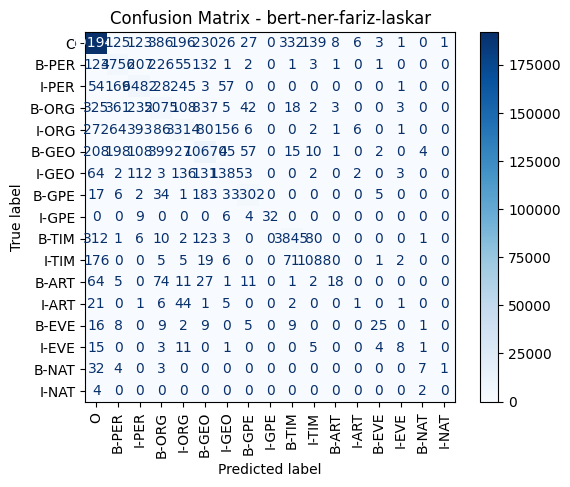


Per-Label Metrics:


,Label,Precision,Recall,F1-score,Accuracy,TP,FP,FN,TN
0,O,0,0,0,0.986277,191940,1703,1603,45664
1,B-PER,0,0,0,0.992964,4756,943,752,234459
2,I-PER,0,0,0,0.992736,6482,1193,557,232678
3,B-ORG,0,0,0,0.986684,5075,1272,1936,232627
4,I-ORG,0,0,0,0.992072,3314,843,1067,235686
5,B-GEO,0,0,0,0.988174,10670,1775,1074,227391
6,I-GEO,0,0,0,0.996791,1385,315,458,238752
7,B-GPE,0,0,0,0.998306,3302,157,251,237200
8,I-GPE,0,0,0,0.999921,32,0,19,240859
9,B-TIM,0,0,0,0.995903,3845,449,538,236078



Overall Metrics:


,Metric,Value
0,Precision,8.265045e-01
1,Recall,8.330568e-01
2,F1-score,8.297677e-01
3,Accuracy,9.627994e-01
4,TP,2.319480e+05
5,FP,8.962000e+03
6,FN,8.962000e+03
7,TN,3.845598e+06


model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Model uploaded at: https://huggingface.co/farizkuy/skripsi-bert-ner-bert-ner-fariz-laskar


In [24]:
# Configuration
trainer = trainer_class.train_model(lr=5e-5, bs=32, epochs=2, config_name="bert-ner-fariz-laskar")
metrics.generate_confusion_matrix(trainer, datasets, config_name="bert-ner-fariz-laskar")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), config_name="bert-ner-fariz-laskar")
